In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Ticker symbol for NASDAQ
nasdaq_ticker = "^IXIC"  
# Ticker symbol for NSE
nse_ticker = "^NSEI"     

nasdaq_data = yf.download(nasdaq_ticker, start="2010-01-01", end="2023-05-01")
nse_data = yf.download(nse_ticker, start="2010-01-01", end="2023-05-01")
nasdaq_close = nasdaq_data['Close']
nse_close = nse_data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculate correlation coefficient
correlation_coefficient = nse_close.corr(nasdaq_close)
print("Correlation Coefficient:", correlation_coefficient)


Correlation Coefficient: 0.9513138758576783


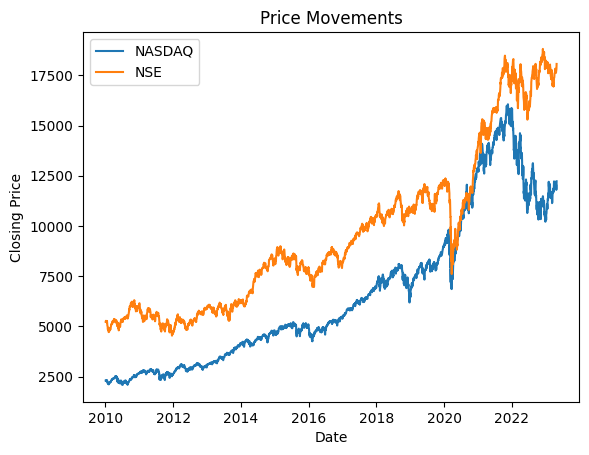

In [4]:
# lead-lag relationship by graphs (METHOD 1)
plt.plot(nasdaq_close, label = 'NASDAQ')
plt.plot(nse_close,label = 'NSE')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Price Movements')
plt.legend()
plt.show()

In [5]:
# correlations with lagged values(METHOD-2)
min_length = min(len(nasdaq_close), len(nse_close))
nasdaq_close = nasdaq_close[:min_length]
nse_close = nse_close[:min_length]

correlation_1 = np.corrcoef(nasdaq_close[:-1], nse_close[1:])[0, 1]
correlation_2 = np.corrcoef(nse_close[:-1], nasdaq_close[1:])[0, 1]

print("Correlation(NASDAQ[i-1], NSE[i]):", correlation_1)
print("Correlation(NSE[i-1], NASDAQ[i]):", correlation_2)

Correlation(NASDAQ[i-1], NSE[i]): 0.9609534454316385
Correlation(NSE[i-1], NASDAQ[i]): 0.9607656842292195


In [6]:
data=yf.download("^NSEI",start="2010-01-01",end="2023-05-01")
def get_kc(high, low, close, kc_lookback, multiplier, a_lookback):
    a = pd.DataFrame(index=high.index)
    a['a1'] = high - low
    a['a2'] = abs(high - close.shift())
    a['a3'] = abs(low - close.shift())
    a['a'] = a.max(axis=1)
    
    aa = a['a'].ewm(alpha=1/a_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = kc_middle + multiplier * aa
    kc_lower = kc_middle - multiplier * aa
    
    return kc_middle, kc_upper, kc_lower

data = data.iloc[:, :4]

data['kc_middle'], data['kc_upper'], data['kc_lower'] = get_kc(data['High'], data['Low'], data['Close'], 4, 2, 10)

def method(prices, kc_upper, kc_lower):
    signals = np.zeros(len(prices))
    
    for i in range(1, len(prices)):
        if prices[i-1] < kc_lower[i-1] and prices[i] > kc_lower[i]:
            signals[i] = 1  # Buy signal
        elif prices[i-1] > kc_upper[i-1] and prices[i] < kc_upper[i]:
            signals[i] = -1  # Sell signal
    
    buy_price = np.where(signals == 1, prices, np.nan)
    sell_price = np.where(signals == -1, prices, np.nan)
    
    return buy_price, sell_price, signals

buy_price, sell_price, kc_signal = method(data['Close'], data['kc_upper'], data['kc_lower'])
data = data[:-1]

buy_kc_df = pd.DataFrame(buy_price)
buy_kc_df = buy_kc_df.fillna(0)
buy_kc_df = buy_kc_df[~(buy_kc_df == 0).all(axis=1)]
sell_kc_df = pd.DataFrame(sell_price)
sell_kc_df = sell_kc_df.fillna(0)
sell_kc_df = sell_kc_df[~(sell_kc_df == 0).all(axis=1)]

# Ensure buy_kc and sell_kc have the same size
buy_kc = np.array(buy_kc_df)
sell_kc = np.array(sell_kc_df)[:buy_kc.shape[0], :]

mean_return = np.mean(sell_kc - buy_kc)
std_deviation = np.std(sell_kc - buy_kc)
print("Cumulative return:", ((sell_kc - buy_kc) / buy_kc).max() )
print("Sharpe Ratio:",  mean_return / std_deviation)
print("Max Drawdown:", (buy_kc - sell_kc).min() / sell_kc[18, 0])

[*********************100%***********************]  1 of 1 completed
Cumulative return: 0.6585267783094598
Sharpe Ratio: 0.5501668747826075
Max Drawdown: -0.46233218957309413


In [7]:
data = yf.download("^NSEI", start="2010-01-01", end="2023-05-01")
data['SMA9'] = data['Close'].rolling(window=5).mean()
std = data['Close'].rolling(window=10).std()
data['upper_bb'] = data['SMA9'] + std * 2.06
data['lower_bb'] = data['SMA9'] - std * 2.06

def method(data, lower_bb, upper_bb):
    buy_price = [np.nan] * len(data)
    sell_price = [np.nan] * len(data)
    bb_signal = [0] * len(data)
    signal = 0

    for i in range(1, len(data)):
        if data[i - 1] > lower_bb[i - 1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price[i] = data[i]
                signal = 1
                bb_signal[i] = signal
        elif data[i - 1] < upper_bb[i - 1] and data[i] > upper_bb[i]:
            if signal != -1:
                sell_price[i] = data[i]
                signal = -1
                bb_signal[i] = signal

    return buy_price, sell_price, bb_signal

buy_price_bb, sell_price_bb, bb_signal = method(data['Close'], data['lower_bb'], data['upper_bb'])

buy_price_bb = pd.DataFrame(buy_price_bb)
buy_price_bb = buy_price_bb.fillna(0)
buy_price_bb = buy_price_bb[~(buy_price_bb == 0).all(axis=1)]
sell_price_bb = pd.DataFrame(sell_price_bb)
sell_price_bb = sell_price_bb.fillna(0)
sell_price_bb = sell_price_bb[~(sell_price_bb == 0).all(axis=1)]
np_buy_bb = np.array(buy_price_bb)
np_sell_bb = np.array(sell_price_bb)
mean_return = np.mean(np_sell_bb - np_buy_bb)
print("Cumulative returns:", ((np_sell_bb - np_buy_bb) / np_buy_bb).max())
print("Sharpe Ratio:", mean_return / np.std(np_sell_bb - np_buy_bb))
print("Max Drawdown:", (np_buy_bb - np_sell_bb).min() / np_sell_bb[6, 0] )


[*********************100%***********************]  1 of 1 completed
Cumulative returns: 0.3450081724579576
Sharpe Ratio: 0.657859301566638
Max Drawdown: -0.25651009378438694


In [8]:
def method(df, fast_period, slow_period, signal_period):
    data = df['Close']
    
    fast_ema = data.ewm(span=fast_period, min_periods=slow_period).mean()
    slow_ema = data.ewm(span=slow_period, min_periods=slow_period).mean()
    macd = pd.Series(fast_ema - slow_ema, name='MACD')
    macd_signal = pd.Series(macd.ewm(span=signal_period, min_periods=signal_period).mean(), name='MACD Signal')
    macd_histogram = pd.Series(macd - macd_signal, name='MACD Histogram')
    
    df = df.join(macd)
    df = df.join(macd_signal)
    df = df.join(macd_histogram)
    
    return df

def generate_signals(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(len(df)):
        if df['MACD'][i] > df['MACD Signal'][i]:
            sell_list.append(np.nan)
            if flag != 1:
                buy_list.append(df['Close'][i])
                flag = 1
            else:
                buy_list.append(np.nan)
        elif df['MACD'][i] < df['MACD Signal'][i]:
            buy_list.append(np.nan)
            if flag != 0:
                sell_list.append(df['Close'][i])
                flag = 0
            else:
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return buy_list, sell_list

df = yf.download("^NSEI", start="2010-01-01", end="2023-05-01")
df_macd = method(df, 50, 113, 50)
signals = generate_signals(df_macd)
df_macd['Buy Signal'] = signals[0]
df_macd['Sell Signal'] = signals[1]

buy_signals = pd.DataFrame(df_macd['Buy Signal']).fillna(0)
buy_signals = buy_signals[~(buy_signals == 0).all(axis=1)]
np_buy_signals = np.array(buy_signals)

sell_signals = pd.DataFrame(df_macd['Sell Signal']).fillna(0)
sell_signals = sell_signals[~(sell_signals == 0).all(axis=1)]
np_sell_signals = np.array(sell_signals)

print("Cumulative Return:", ((np_sell_signals - np_buy_signals) / np_buy_signals).max() )
print("Sharpe Ratio:", (np_sell_signals - np_buy_signals).mean() / np_sell_signals.std())
print("Maximum Drawdown:", (np_buy_signals - np_sell_signals).min() / np_sell_signals[22, 0])


[*********************100%***********************]  1 of 1 completed
Cumulative Return: 0.4515609752012649
Sharpe Ratio: 0.09153560208938014
Maximum Drawdown: -0.3780369086183096
